Skipping model A due to missing training data for month: Apr


22:18:29 - cmdstanpy - INFO - Chain [1] start processing
22:18:29 - cmdstanpy - INFO - Chain [1] done processing


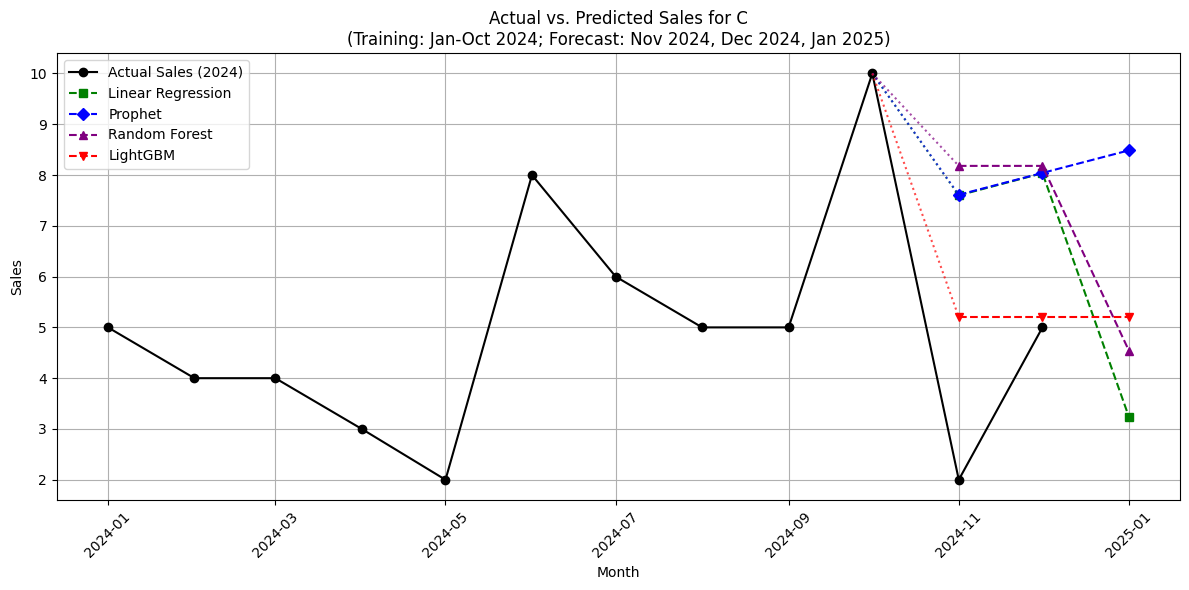

22:18:29 - cmdstanpy - INFO - Chain [1] start processing
22:18:29 - cmdstanpy - INFO - Chain [1] done processing


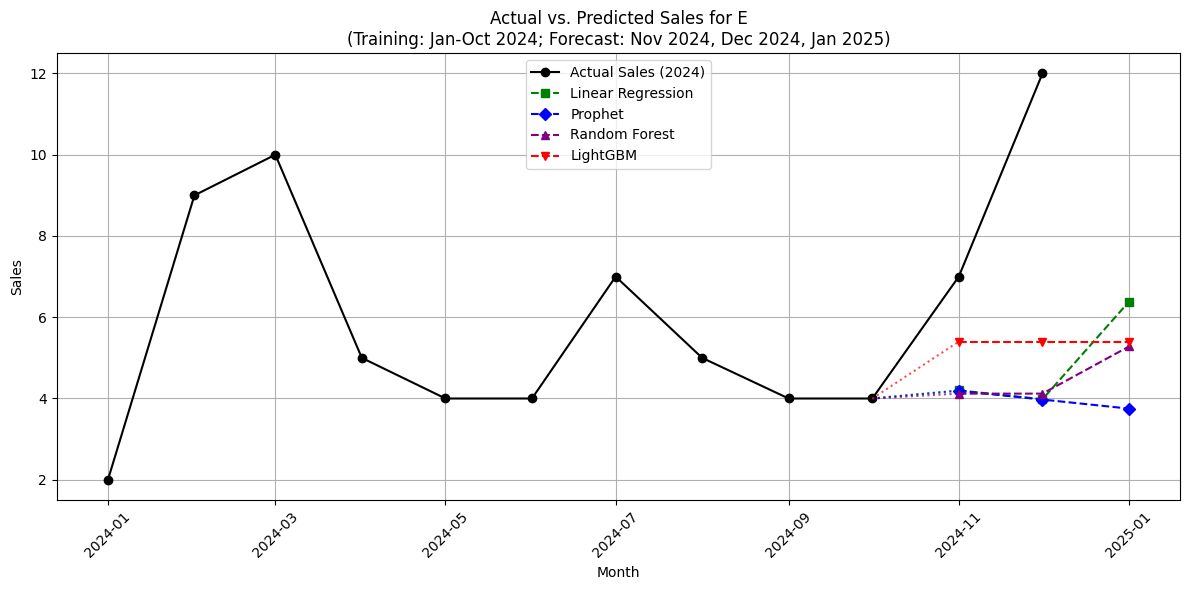

22:18:30 - cmdstanpy - INFO - Chain [1] start processing
22:18:30 - cmdstanpy - INFO - Chain [1] done processing


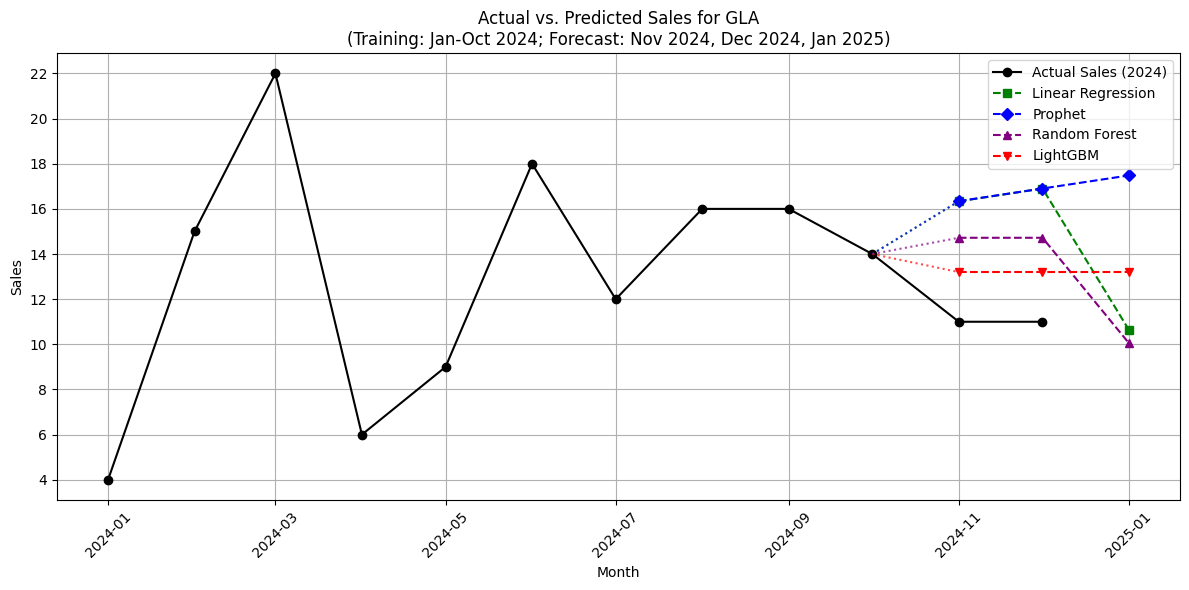

22:18:30 - cmdstanpy - INFO - Chain [1] start processing
22:18:30 - cmdstanpy - INFO - Chain [1] done processing


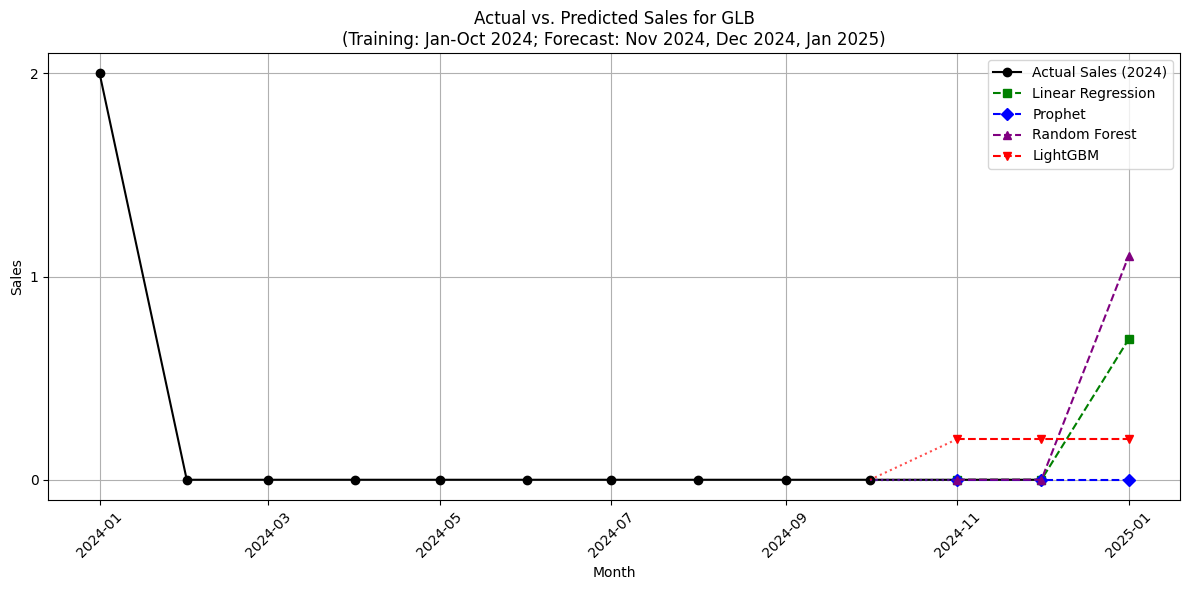

22:18:31 - cmdstanpy - INFO - Chain [1] start processing
22:18:31 - cmdstanpy - INFO - Chain [1] done processing


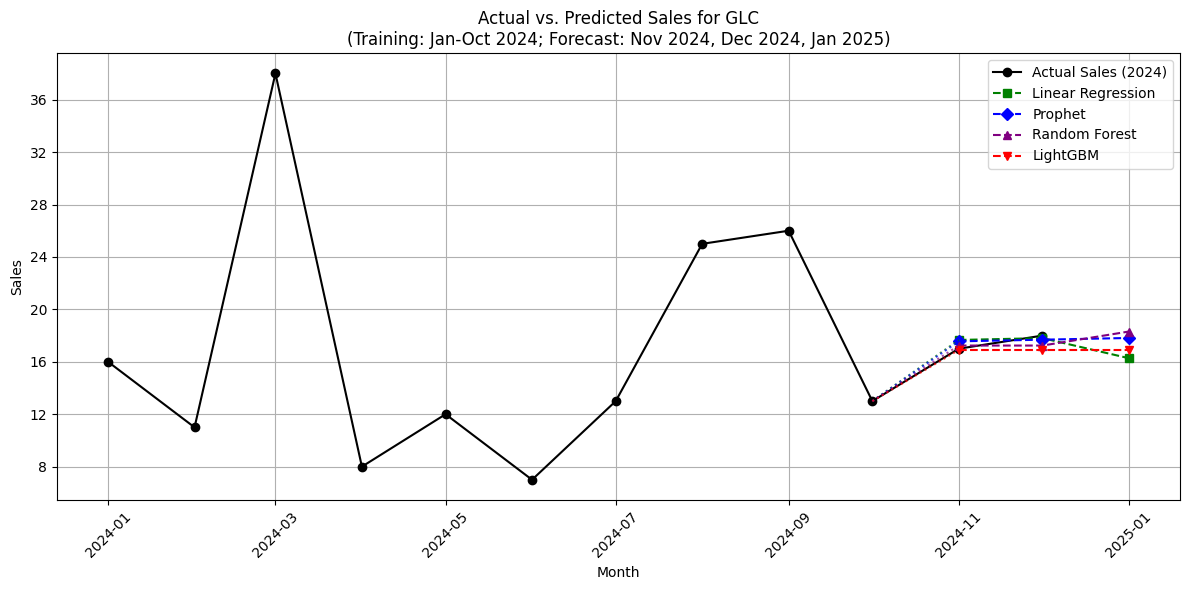

22:18:31 - cmdstanpy - INFO - Chain [1] start processing
22:18:31 - cmdstanpy - INFO - Chain [1] done processing


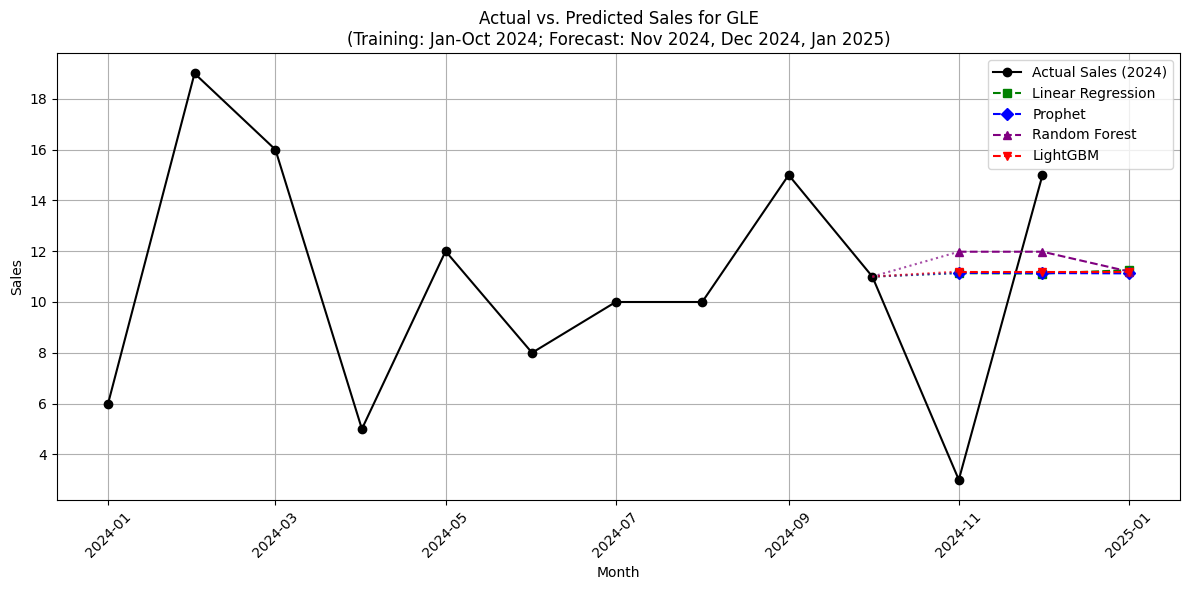

22:18:32 - cmdstanpy - INFO - Chain [1] start processing
22:18:32 - cmdstanpy - INFO - Chain [1] done processing


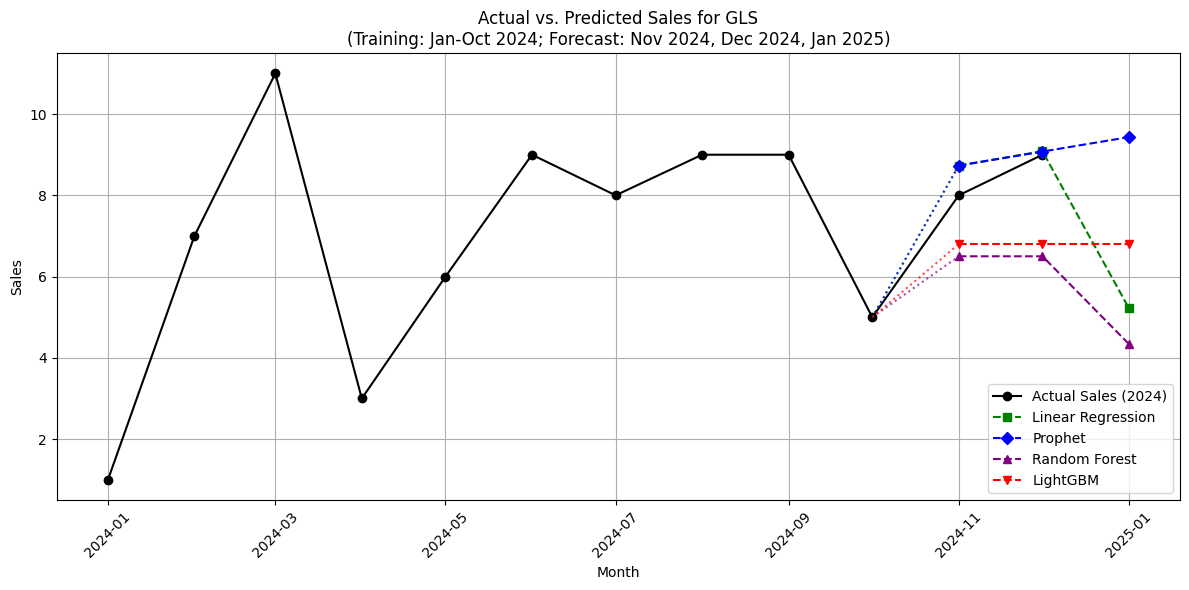

22:18:32 - cmdstanpy - INFO - Chain [1] start processing
22:18:32 - cmdstanpy - INFO - Chain [1] done processing


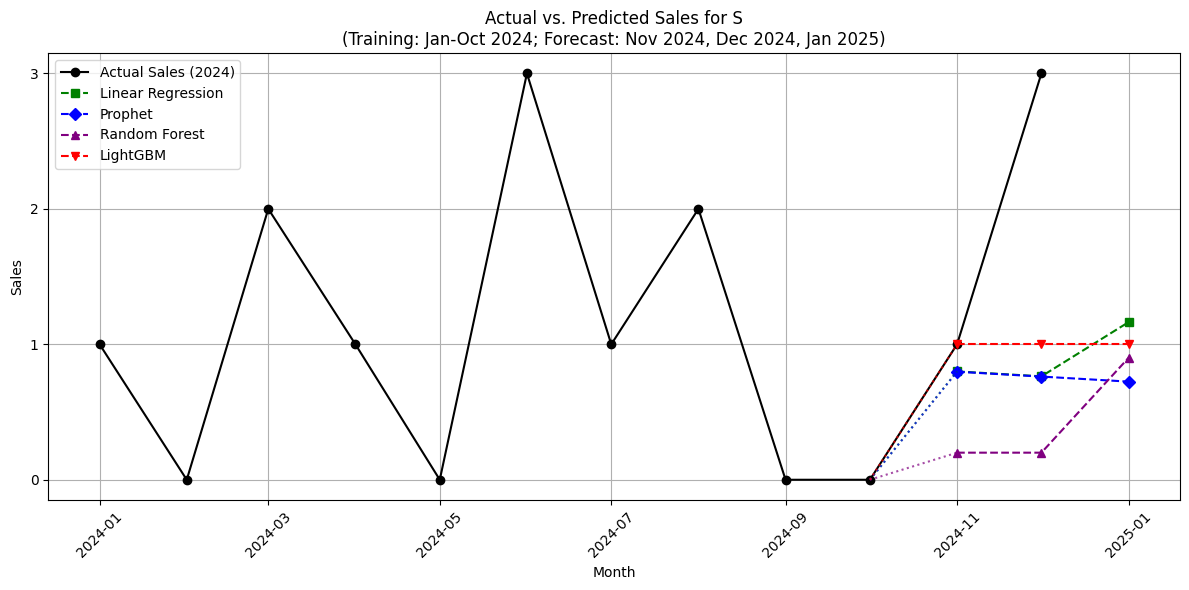

22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing


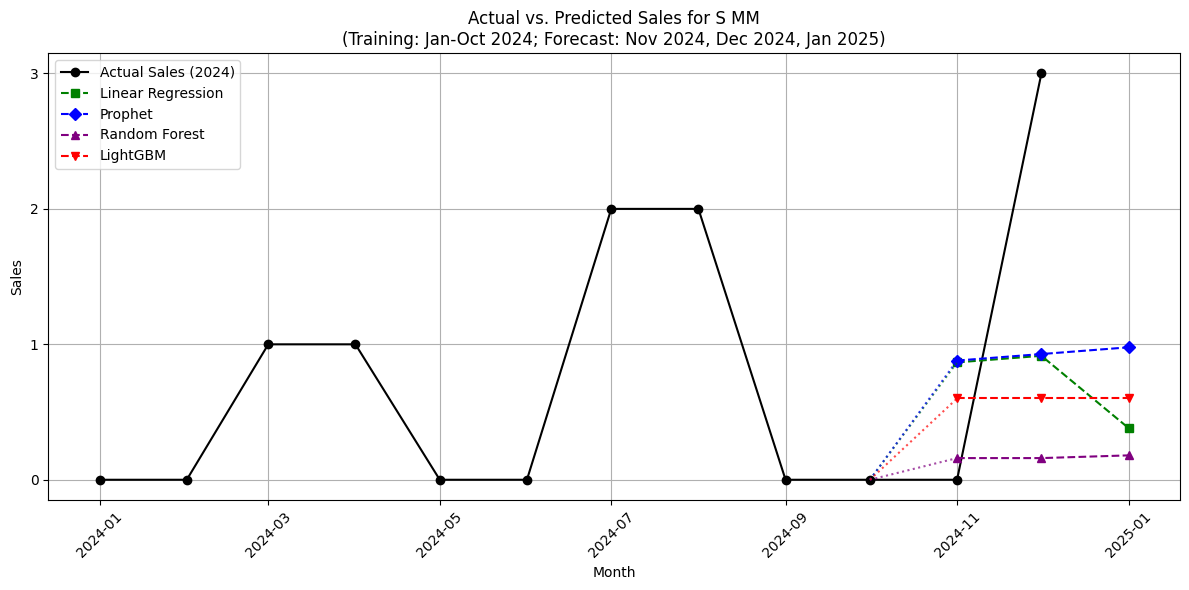

22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing


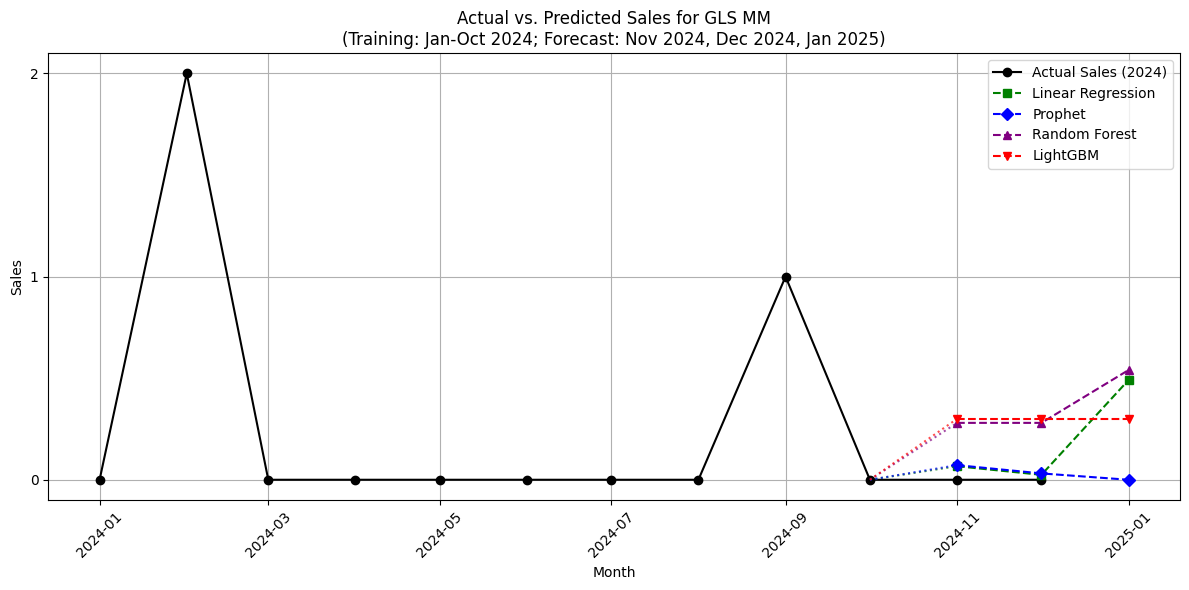

22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing


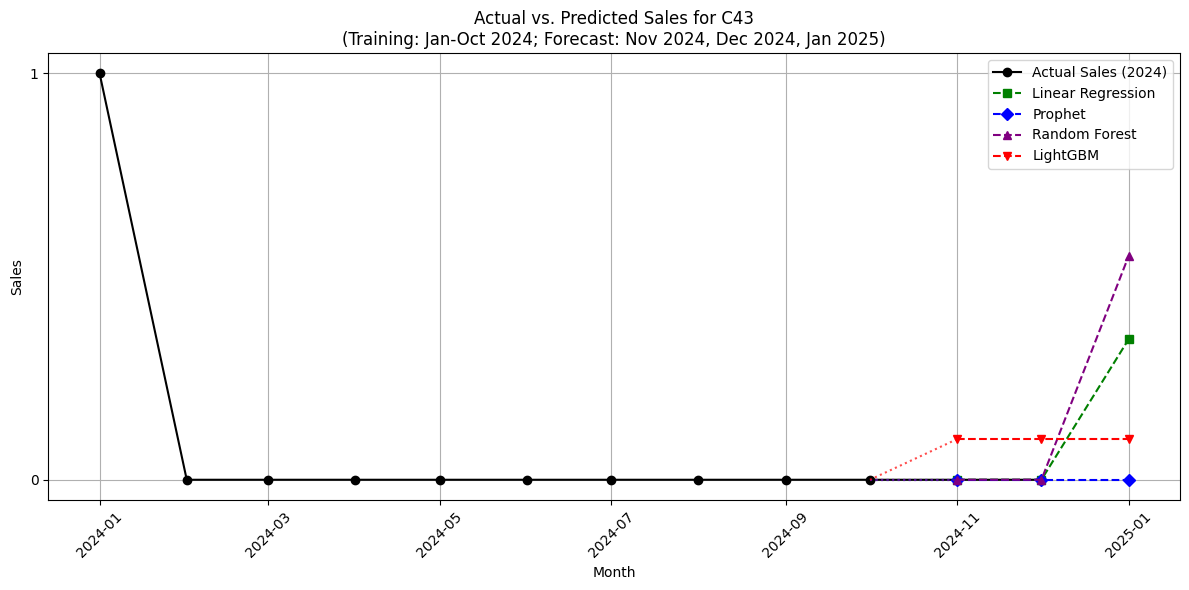

22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing


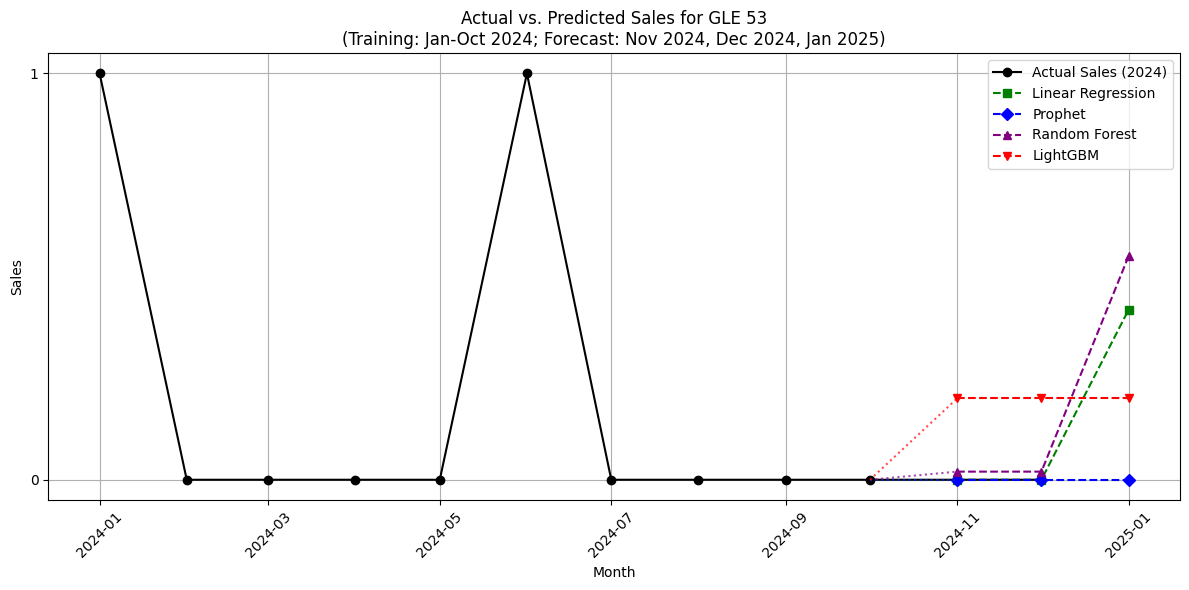

22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing


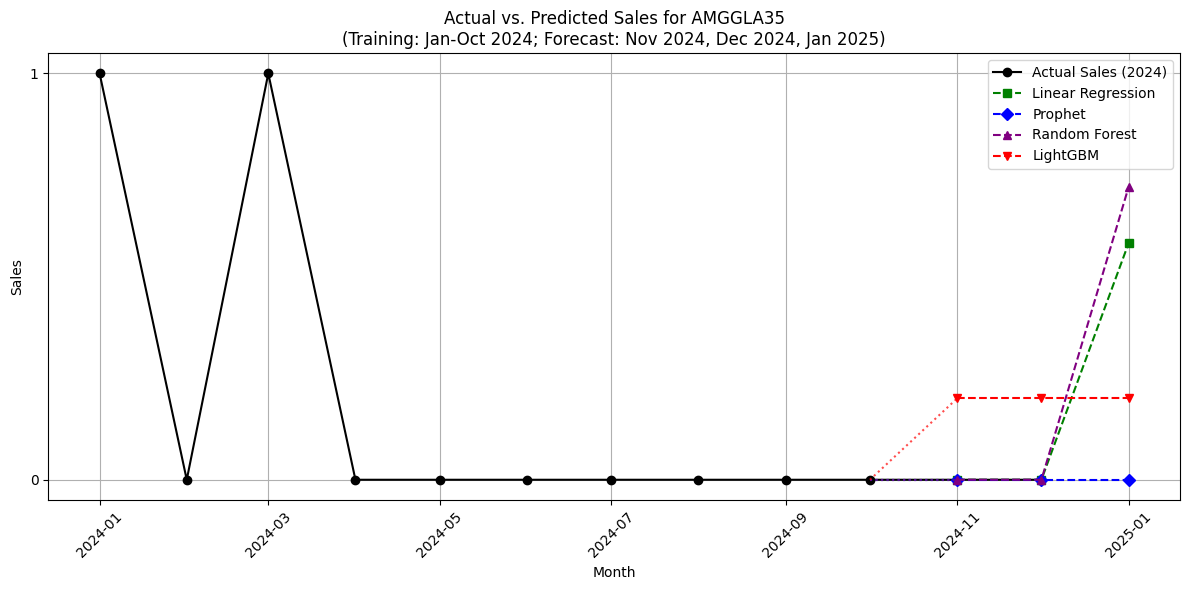

22:18:35 - cmdstanpy - INFO - Chain [1] start processing
22:18:35 - cmdstanpy - INFO - Chain [1] done processing


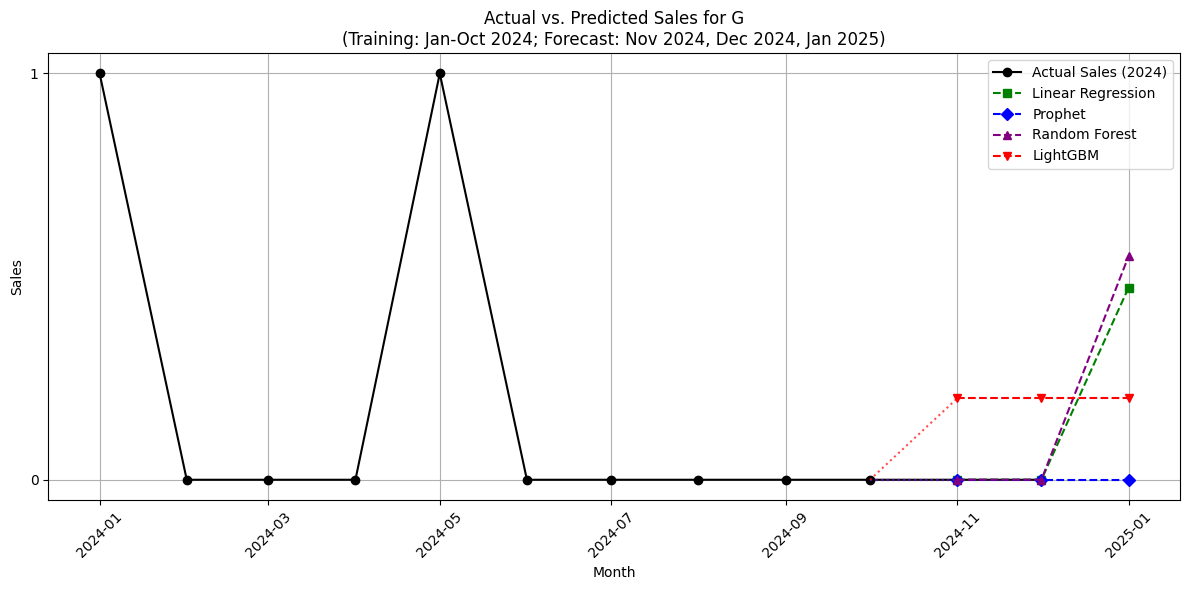

22:18:35 - cmdstanpy - INFO - Chain [1] start processing
22:18:35 - cmdstanpy - INFO - Chain [1] done processing


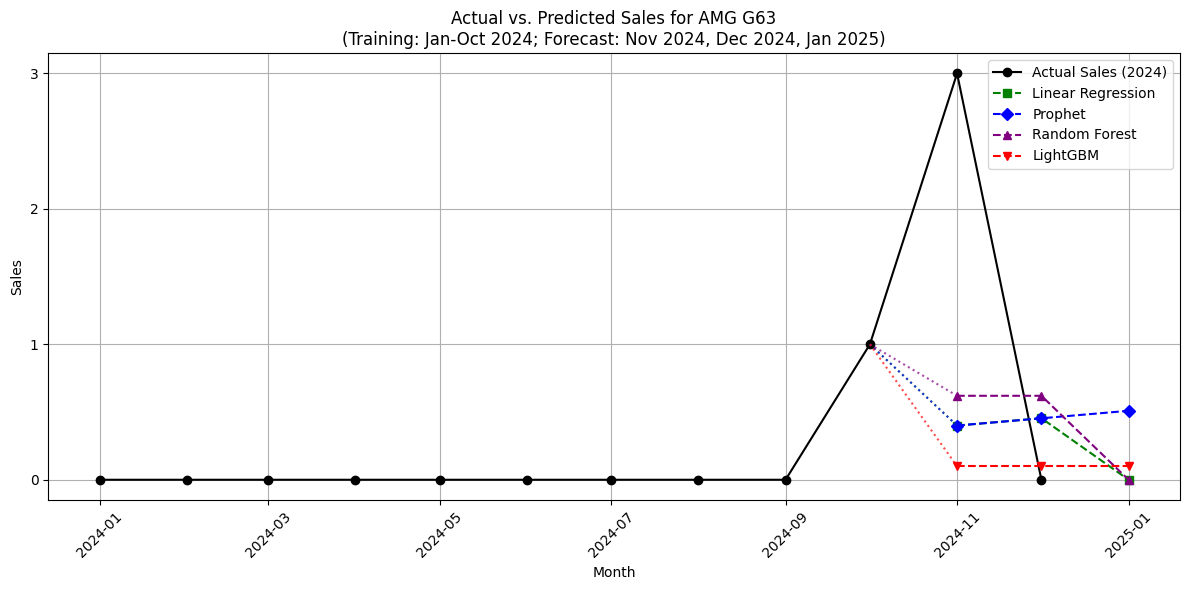

22:18:36 - cmdstanpy - INFO - Chain [1] start processing
22:18:36 - cmdstanpy - INFO - Chain [1] done processing


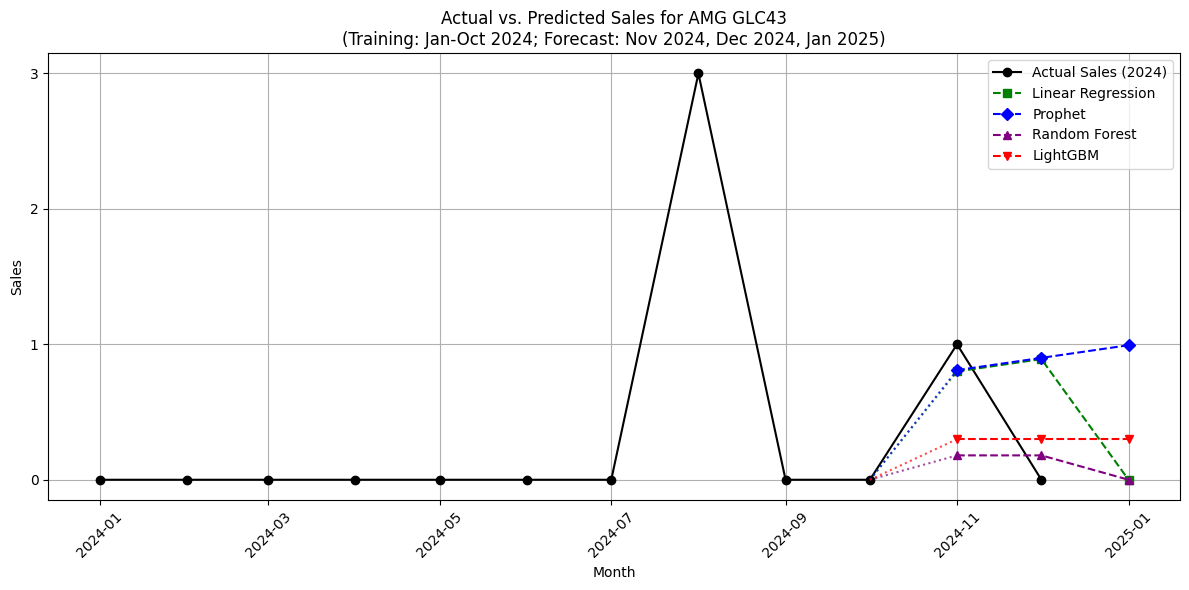

22:18:36 - cmdstanpy - INFO - Chain [1] start processing
22:18:36 - cmdstanpy - INFO - Chain [1] done processing


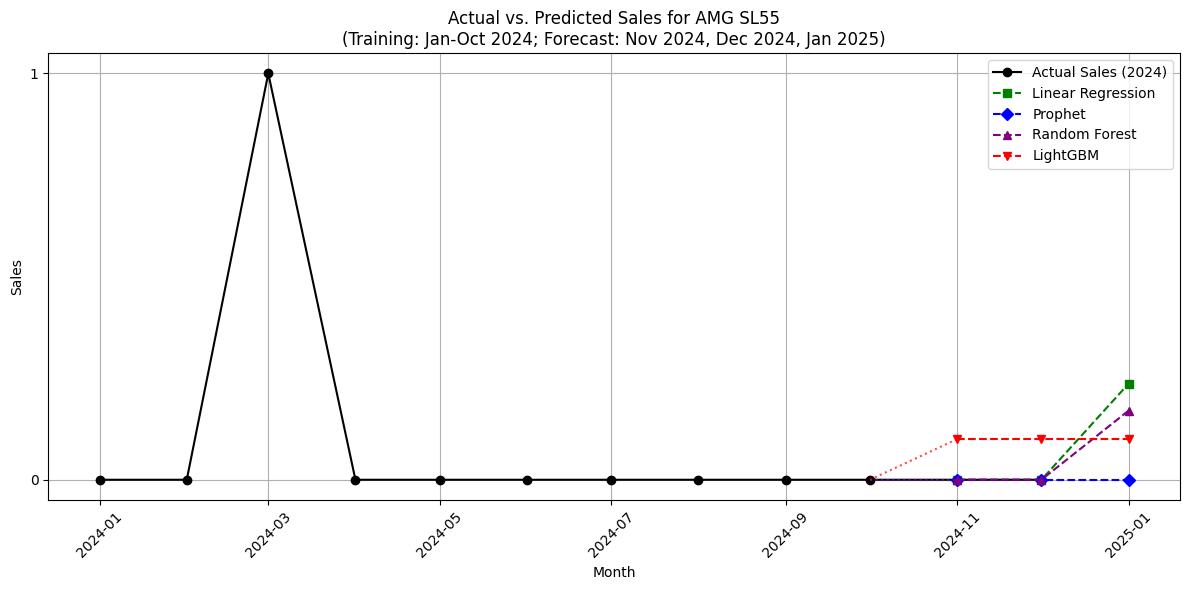

22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:37 - cmdstanpy - INFO - Chain [1] done processing


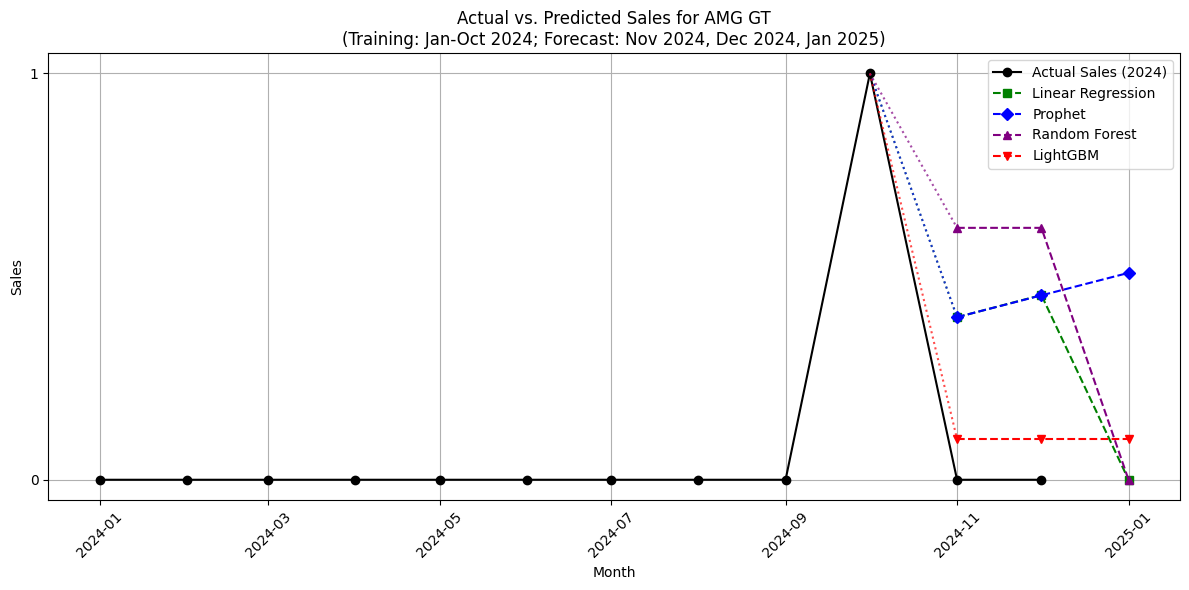

22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:37 - cmdstanpy - INFO - Chain [1] done processing


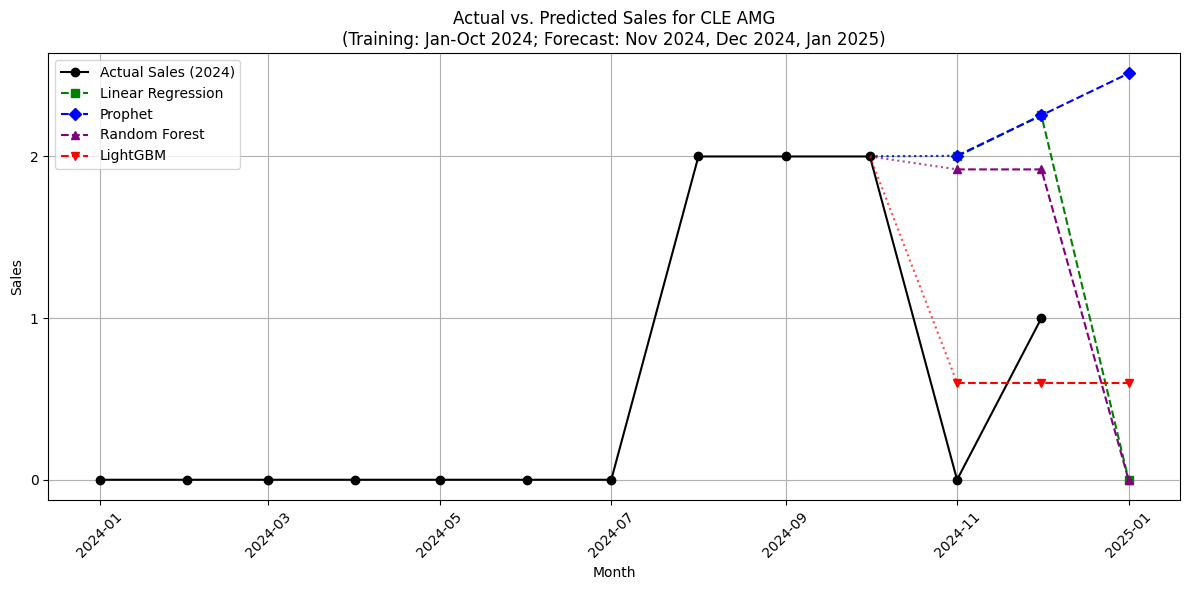

22:18:38 - cmdstanpy - INFO - Chain [1] start processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing


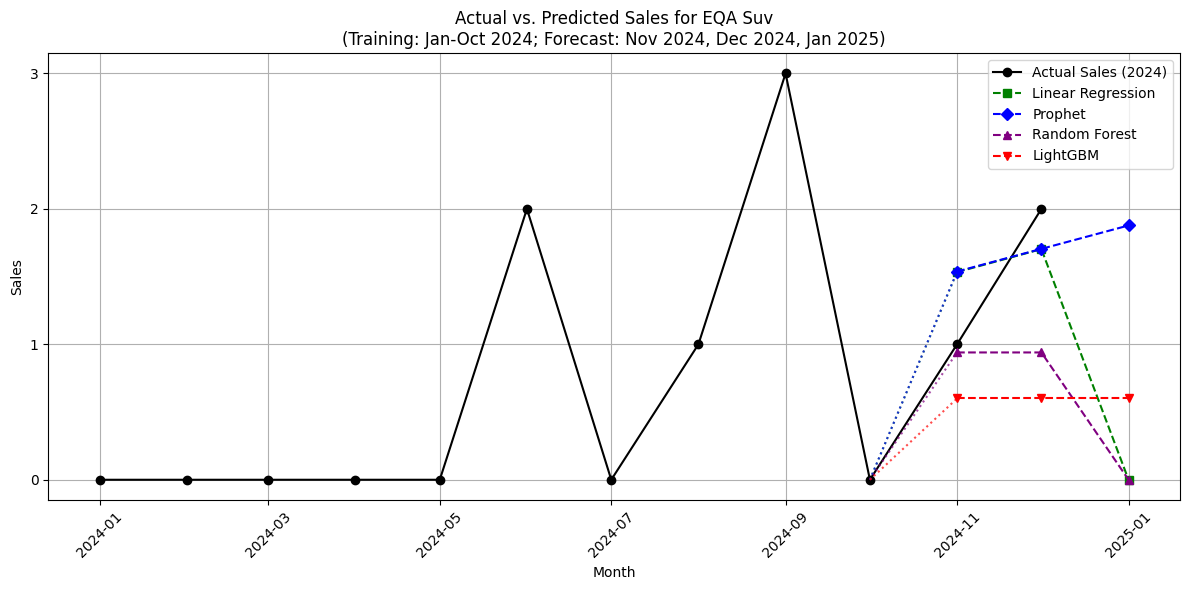

22:18:38 - cmdstanpy - INFO - Chain [1] start processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing


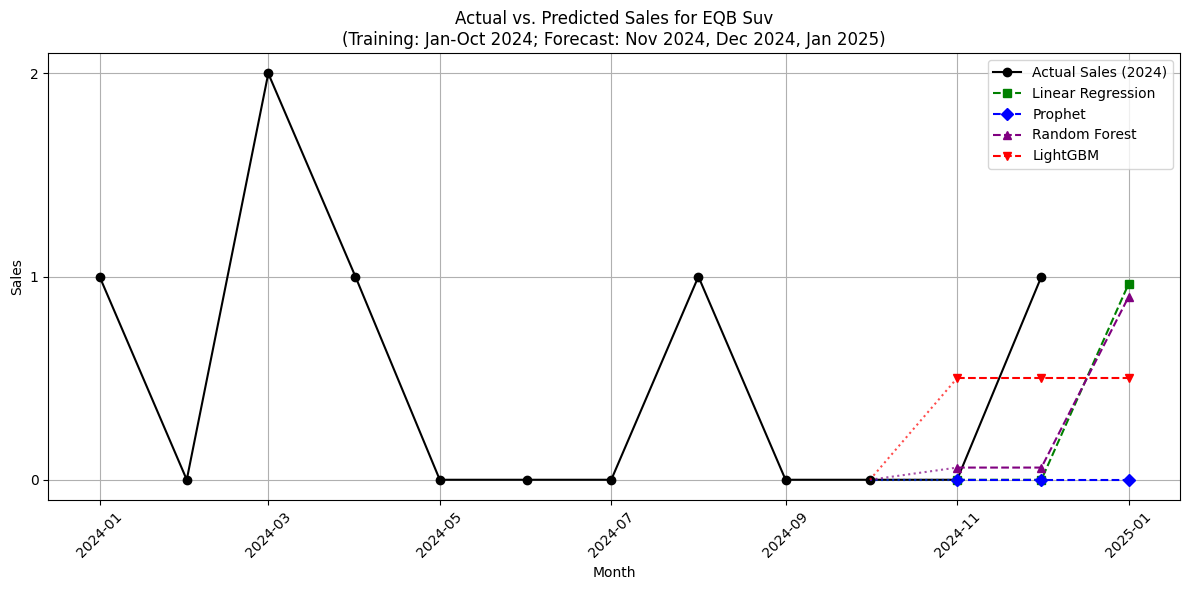

22:18:38 - cmdstanpy - INFO - Chain [1] start processing
22:18:39 - cmdstanpy - INFO - Chain [1] done processing


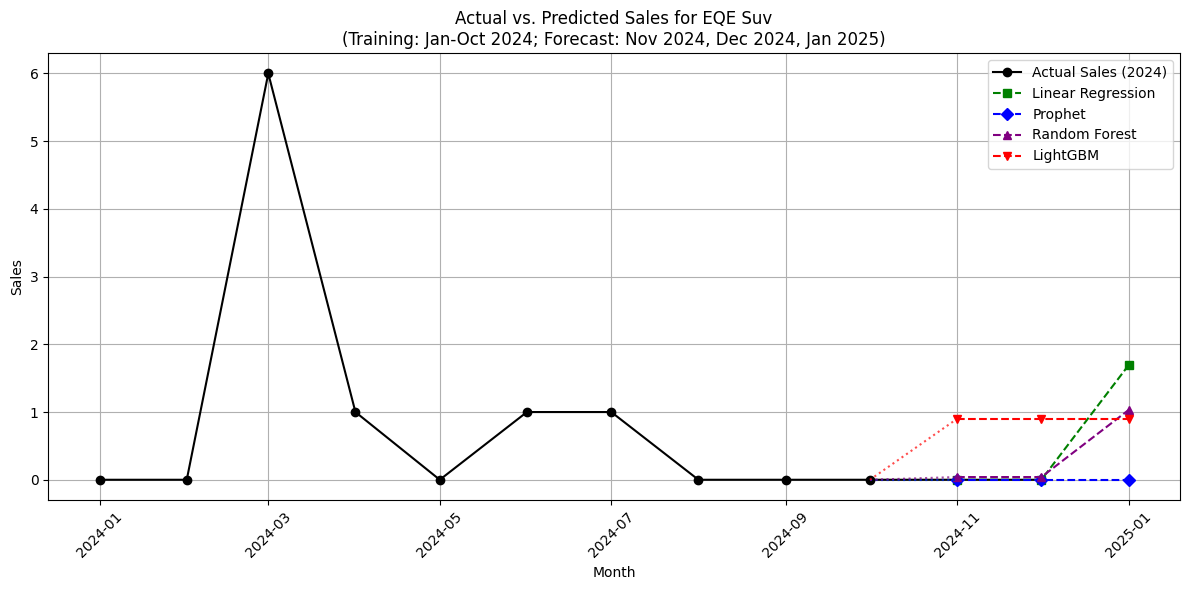

22:18:39 - cmdstanpy - INFO - Chain [1] start processing
22:18:39 - cmdstanpy - INFO - Chain [1] done processing


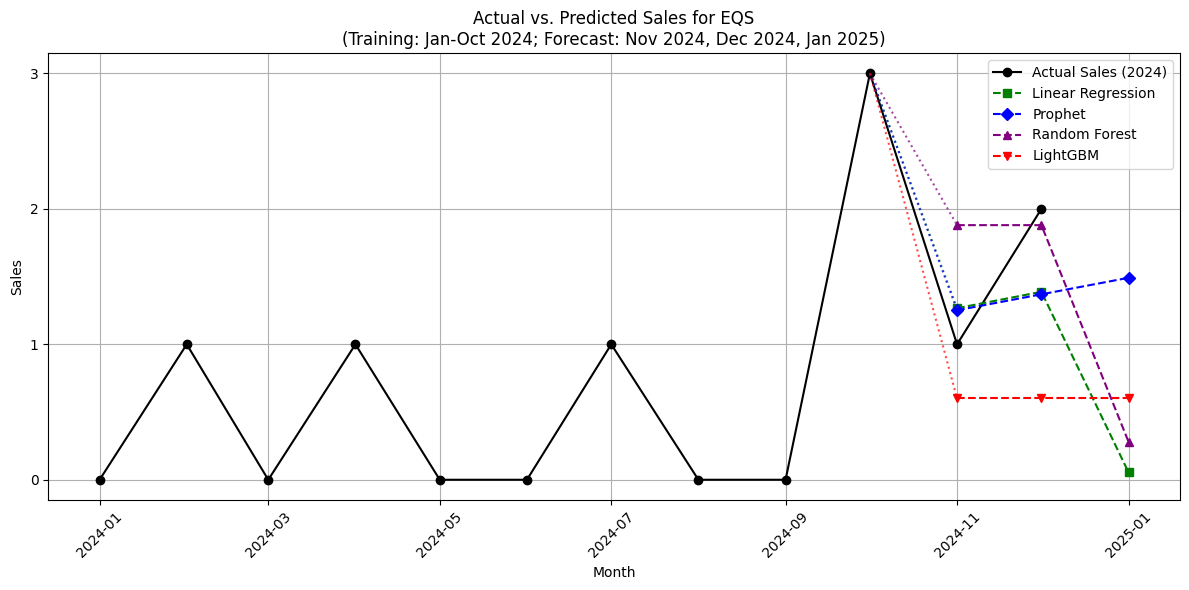

22:18:39 - cmdstanpy - INFO - Chain [1] start processing
22:18:39 - cmdstanpy - INFO - Chain [1] done processing


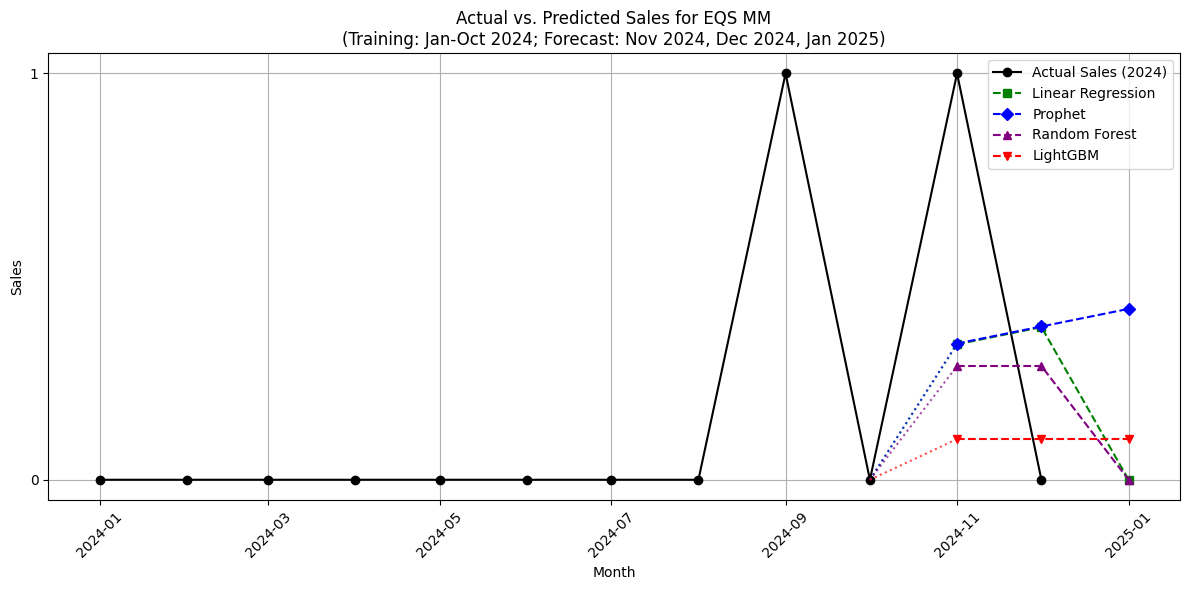

22:18:40 - cmdstanpy - INFO - Chain [1] start processing
22:18:40 - cmdstanpy - INFO - Chain [1] done processing


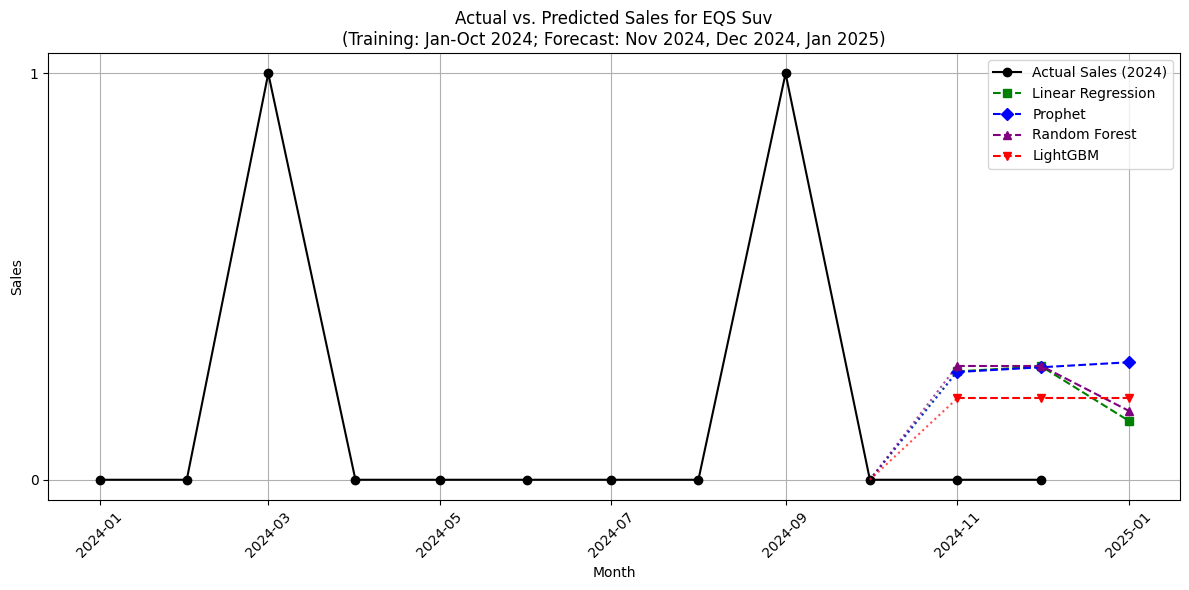

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from datetime import datetime
import warnings
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings('ignore')

# =============================================================================
# 1. Data Preparation Function
# =============================================================================
def prepare_features(df):
    """
    Convert string-based columns into numeric values and create extra features.
    """
    df['Price_Numeric'] = df['Price of Model'].str.replace(',', '').astype(float)
    df['Power_HP'] = df['Power / Torque'].str.extract(r'(\d+)').astype(float)
    df['Mileage_Numeric'] = df['Mileage / Range'].str.extract(r'(\d+)').astype(float)
    df['Is_SUV'] = (df['Type of Car'] == 'SUV').astype(int)
    df['Is_Sedan'] = (df['Type of Car'] == 'Sedan').astype(int)
    df['Is_Electric'] = (df['Type of Fuel'] == 'Electric').astype(int)
    return df

# =============================================================================
# 2. Load and Prepare Data
# =============================================================================
df = pd.read_csv('Mercedes_sales_data_with_models.csv')
df = prepare_features(df)

# Define month lists:
# Training: January–October 2024
# Future: November 2024, December 2024, and January 2025
training_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct']
full_actual_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
future_months = ['Nov', 'Dec', 'Jan']  # Note: Nov & Dec are in 2024; Jan is in 2025

# Mapping month names to month numbers (used as a feature and to construct dates)
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
    'July': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# =============================================================================
# 3. Loop Over Each Car Model and Train Four Models
# =============================================================================
for model_name in df['Model Name'].dropna().unique():
    # Get the row for the current car model
    row = df[df['Model Name'] == model_name].iloc[0]
    
    # ----------------------------
    # Prepare Training Data for ML models
    # ----------------------------
    # Check if any training month has missing sales data; if so, skip this model.
    training_values = []
    skip_model = False
    for m in training_months:
        val = row[m]
        if pd.isna(val):
            print(f"Skipping model {model_name} due to missing training data for month: {m}")
            skip_model = True
            break
        training_values.append(float(val))
    if skip_model:
        continue

    # Prepare the training features DataFrame
    X_train = pd.DataFrame({
        'Month_Num': [month_mapping[m] for m in training_months],
        'Price_Numeric': [row['Price_Numeric']] * len(training_months),
        'Power_HP': [row['Power_HP']] * len(training_months),
        'Mileage_Numeric': [row['Mileage_Numeric']] * len(training_months),
        'Is_SUV': [row['Is_SUV']] * len(training_months),
        'Is_Sedan': [row['Is_Sedan']] * len(training_months),
        'Is_Electric': [row['Is_Electric']] * len(training_months)
    })
    y_train = pd.Series(training_values)
    
    # Prepare future prediction data for ML models
    X_pred = pd.DataFrame({
        'Month_Num': [month_mapping[m] for m in future_months],
        'Price_Numeric': [row['Price_Numeric']] * len(future_months),
        'Power_HP': [row['Power_HP']] * len(future_months),
        'Mileage_Numeric': [row['Mileage_Numeric']] * len(future_months),
        'Is_SUV': [row['Is_SUV']] * len(future_months),
        'Is_Sedan': [row['Is_Sedan']] * len(future_months),
        'Is_Electric': [row['Is_Electric']] * len(future_months)
    })
    
    # ----------------------------
    # Train Linear Regression Model
    # ----------------------------
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    pred_lin = lin_model.predict(X_pred)
    # Ensure predictions are not less than 0
    pred_lin = np.maximum(pred_lin, 0)
    
    # ----------------------------
    # Train Random Forest Regressor
    # ----------------------------
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    pred_rf = rf_model.predict(X_pred)
    pred_rf = np.maximum(pred_rf, 0)
    
    # ----------------------------
    # Train LightGBM Regressor
    # ----------------------------
    lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=31, random_state=42)
    lgb_model.fit(X_train, y_train)
    pred_lgb = lgb_model.predict(X_pred)
    pred_lgb = np.maximum(pred_lgb, 0)
    
    # ----------------------------
    # Train Prophet Model
    # ----------------------------
    # Prophet requires a DataFrame with columns 'ds' and 'y'
    prophet_train = pd.DataFrame({
        'ds': [datetime.strptime(f"2024-{month_mapping[m]:02d}-01", "%Y-%m-%d") for m in training_months],
        'y': training_values
    })
    prophet_model = Prophet()
    prophet_model.fit(prophet_train)
    # Construct future dates for Prophet predictions
    future_dates = []
    for m in future_months:
        if m == 'Jan':  # January belongs to 2025
            future_dates.append(datetime.strptime("2025-01-01", "%Y-%m-%d"))
        else:
            future_dates.append(datetime.strptime(f"2024-{month_mapping[m]:02d}-01", "%Y-%m-%d"))
    future_prophet = pd.DataFrame({'ds': future_dates})
    forecast = prophet_model.predict(future_prophet)
    pred_prophet = forecast['yhat'].values
    pred_prophet = np.maximum(pred_prophet, 0)
    
    # ----------------------------
    # Prepare Actual Sales for Comparison
    # ----------------------------
    # Actual sales for all months Jan–Dec 2024 (to compare predictions for Nov & Dec)
    actual_sales = []
    actual_dates = []
    for m in full_actual_months:
        sale = row[m]
        # If actual sale is missing, fill with NaN (or you could choose to fill with 0)
        if pd.isna(sale):
            sale = np.nan
        else:
            sale = float(sale)
        actual_sales.append(sale)
        actual_dates.append(datetime.strptime(f"2024-{month_mapping[m]:02d}-01", "%Y-%m-%d"))
    
    # ----------------------------
    # Prepare Dates for Predictions
    # ----------------------------
    pred_dates = []
    for m in future_months:
        if m == 'Jan':
            pred_dates.append(datetime.strptime("2025-01-01", "%Y-%m-%d"))
        else:
            pred_dates.append(datetime.strptime(f"2024-{month_mapping[m]:02d}-01", "%Y-%m-%d"))
    
    # ----------------------------
    # Plot: Actual vs. Predictions from 4 Models
    # ----------------------------
    plt.figure(figsize=(12, 6))
    
    # Plot actual sales (black line)
    plt.plot(actual_dates, actual_sales, label='Actual Sales (2024)', marker='o', color='black')
    
    # Plot predictions from each model over future months:
    plt.plot(pred_dates, pred_lin, label='Linear Regression', marker='s', linestyle='--', color='green')
    plt.plot(pred_dates, pred_prophet, label='Prophet', marker='D', linestyle='--', color='blue')
    plt.plot(pred_dates, pred_rf, label='Random Forest', marker='^', linestyle='--', color='purple')
    plt.plot(pred_dates, pred_lgb, label='LightGBM', marker='v', linestyle='--', color='red')
    
    # Optionally, draw connecting lines from the last training point (October 2024) to the forecasts
    last_train_date = datetime.strptime("2024-10-01", "%Y-%m-%d")
    last_train_sale = float(row['Oct'])
    for pred, col in zip([pred_lin, pred_prophet, pred_rf, pred_lgb],
                          ['green', 'blue', 'purple', 'red']):
        plt.plot([last_train_date, pred_dates[0]], [last_train_sale, pred[0]],
                 linestyle=':', color=col, alpha=0.7)
    
    plt.title(f"Actual vs. Predicted Sales for {model_name}\n(Training: Jan-Oct 2024; Forecast: Nov 2024, Dec 2024, Jan 2025)")
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    
    # Ensure y-axis shows only integer ticks
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


22:19:14 - cmdstanpy - INFO - Chain [1] start processing
22:19:14 - cmdstanpy - INFO - Chain [1] done processing
22:19:14 - cmdstanpy - INFO - Chain [1] start processing


Predictions for November and December (trained using data till October):

Linear Regression:
  November Prediction: 82.00 (Actual: 58)
  December Prediction: 84.36 (Actual: 86)
  Mean Absolute Error: 12.82

Random Forest:
  November Prediction: 78.38 (Actual: 58)
  December Prediction: 78.38 (Actual: 86)
  Mean Absolute Error: 14.00

LightGBM:
  November Prediction: 69.00 (Actual: 58)
  December Prediction: 69.00 (Actual: 86)
  Mean Absolute Error: 14.00

SVR:
  November Prediction: 73.80 (Actual: 58)
  December Prediction: 73.71 (Actual: 86)
  Mean Absolute Error: 14.05

Prophet:
  November Prediction: 81.92 (Actual: 58)
  December Prediction: 84.29 (Actual: 86)
  Mean Absolute Error: 12.81


22:19:14 - cmdstanpy - INFO - Chain [1] done processing



Predictions for January 2025 (using full-year data):
  Linear Regression: 80.36
  Random Forest: 80.58
  LightGBM: 69.50
  SVR: 78.06
  Prophet: 79.89


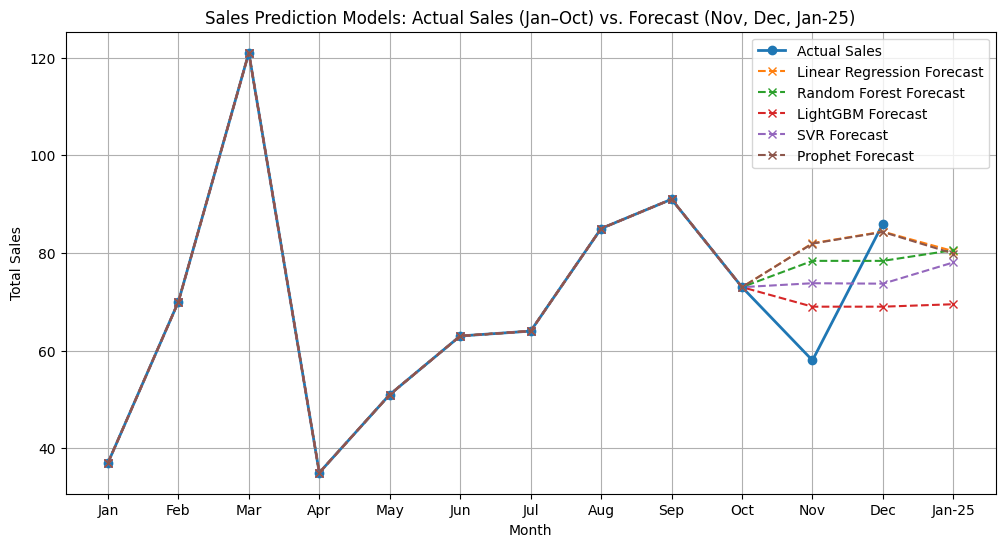

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning Models & Utilities
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# Prophet for time series forecasting
from prophet import Prophet

# -----------------------------------
# 1. Data Preparation & Feature Engineering
# -----------------------------------
data = {
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'Total Sales': [37, 70, 121, 35, 51, 63, 64, 85, 91, 73, 58, 86]
}
df = pd.DataFrame(data)
df['Month_Num'] = range(1, len(df) + 1)

# Split data: Use data till October for training; November & December actuals for testing
train_df = df.iloc[:10]  # January to October
test_df  = df.iloc[10:]  # November and December (for comparison)

# -----------------------------------
# 2. Prepare Features and Scale Them (for ML models)
# -----------------------------------
train_X = train_df[['Month_Num']]
train_y = train_df['Total Sales']

# Prepare future features for prediction (November and December)
future_months = pd.DataFrame({'Month_Num': [11, 12]})

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
future_months_scaled = scaler.transform(future_months)

# -----------------------------------
# 3. Define the Prediction Models (5 Models)
# -----------------------------------
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
}

# Dictionary to hold predictions and MAE scores for November & December
predictions = {}
mae_scores = {}

# Train each model using data till October and predict for November & December
for name, model in models.items():
    model.fit(train_X_scaled, train_y)
    pred = model.predict(future_months_scaled)
    predictions[name] = pred
    mae = mean_absolute_error(test_df['Total Sales'], pred)
    mae_scores[name] = mae

# Prophet requires a dataframe with dates. Prepare the training dataframe for Prophet.
prophet_train_df = pd.DataFrame({
    'ds': pd.date_range(start='2024-01-01', periods=len(train_df), freq='M'),
    'y': train_df['Total Sales']
})
prophet_model = Prophet()
prophet_model.fit(prophet_train_df)
# Forecast 2 future periods (November and December)
future_dates = prophet_model.make_future_dataframe(periods=2, freq='M')
forecast = prophet_model.predict(future_dates)
# Get the predictions corresponding to November and December (the last 2 rows)
prophet_preds = forecast.iloc[-2:]['yhat'].values
predictions['Prophet'] = prophet_preds
mae_scores['Prophet'] = mean_absolute_error(test_df['Total Sales'], prophet_preds)

# -----------------------------------
# 4. Print Predictions and MAE for November and December
# -----------------------------------
print("Predictions for November and December (trained using data till October):")
for name, pred in predictions.items():
    print(f"\n{name}:")
    print(f"  November Prediction: {pred[0]:.2f} (Actual: {test_df.iloc[0]['Total Sales']})")
    print(f"  December Prediction: {pred[1]:.2f} (Actual: {test_df.iloc[1]['Total Sales']})")
    print(f"  Mean Absolute Error: {mae_scores[name]:.2f}")

# -----------------------------------
# 5. Future Prediction for January
# -----------------------------------
# For January forecasting, we now use the full-year data.
full_X = df[['Month_Num']]
full_y = df['Total Sales']
full_X_scaled = scaler.fit_transform(full_X)

january_predictions = {}
# For regression, forest, LightGBM, and SVR models:
for name, model in models.items():
    model.fit(full_X_scaled, full_y)
    jan_pred = model.predict(scaler.transform([[13]]))[0]  # January is month 13
    january_predictions[name] = jan_pred

# Prophet prediction for January using full data:
prophet_full_df = pd.DataFrame({
    'ds': pd.date_range(start='2024-01-01', periods=len(df), freq='M'),
    'y': df['Total Sales']
})
prophet_model_full = Prophet()
prophet_model_full.fit(prophet_full_df)
future_full = prophet_model_full.make_future_dataframe(periods=1, freq='M')
jan_forecast = prophet_model_full.predict(future_full)
january_predictions['Prophet'] = jan_forecast.iloc[-1]['yhat']

print("\nPredictions for January 2025 (using full-year data):")
for name, pred in january_predictions.items():
    print(f"  {name}: {pred:.2f}")

# -----------------------------------
# 6. Visualization: Actual vs. Predicted Sales with Forecast Divergence after October
# -----------------------------------
# We want the graph to match actual sales for January–October, then show forecast differences for November, December, and January.

# Create an x-axis for 13 months: Jan to Dec from the dataset, plus Jan-2025 as the future month.
month_labels = list(df['Month']) + ['Jan-25']

# Prepare the actual sales series: actual values for Jan-Dec; no actual for Jan-25.
actual_series = list(df['Total Sales']) + [np.nan]

# For each model, create a full 13-point series:
# For months 1-10, we use actual sales (forcing the lines to be the same as actual).
# For November and December, we use the predictions from the model (trained with data till October).
# For January, we use the January prediction (from full-year data).
predicted_series = {}
for name in list(models.keys()) + ['Prophet']:
    # Use actual sales for months Jan–Oct
    series = list(df['Total Sales'].iloc[:10])
    # Append predictions for November and December (from the "predictions" dictionary)
    series.append(predictions[name][0])  # November
    series.append(predictions[name][1])  # December
    # Append January prediction (from january_predictions)
    series.append(january_predictions[name])
    predicted_series[name] = series

# Plot the actual sales and predicted forecasts
plt.figure(figsize=(12, 6))
plt.plot(month_labels, actual_series, label='Actual Sales', marker='o', linewidth=2)

# Plot each model's forecast series
for name, series in predicted_series.items():
    plt.plot(month_labels, series, linestyle='--', marker='x', label=f'{name} Forecast')

plt.title('Sales Prediction Models: Actual Sales (Jan–Oct) vs. Forecast (Nov, Dec, Jan-25)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


22:30:10 - cmdstanpy - INFO - Chain [1] start processing
22:30:10 - cmdstanpy - INFO - Chain [1] done processing


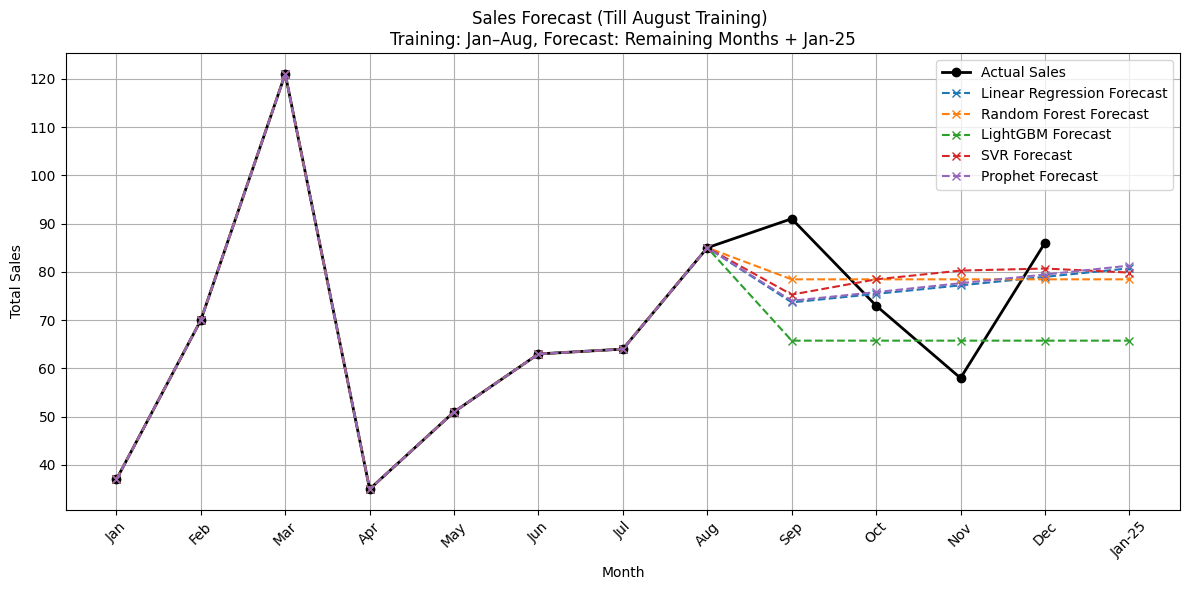

22:30:10 - cmdstanpy - INFO - Chain [1] start processing



Error Metrics for Forecasts with Training Till August (Forecast months with actual data):
  Linear Regression: MAE = 11.50
  Random Forest: MAE = 11.50
  LightGBM: MAE = 15.12
  SVR: MAE = 12.18
  Prophet: MAE = 11.50
------------------------------------------------------------


22:30:10 - cmdstanpy - INFO - Chain [1] done processing


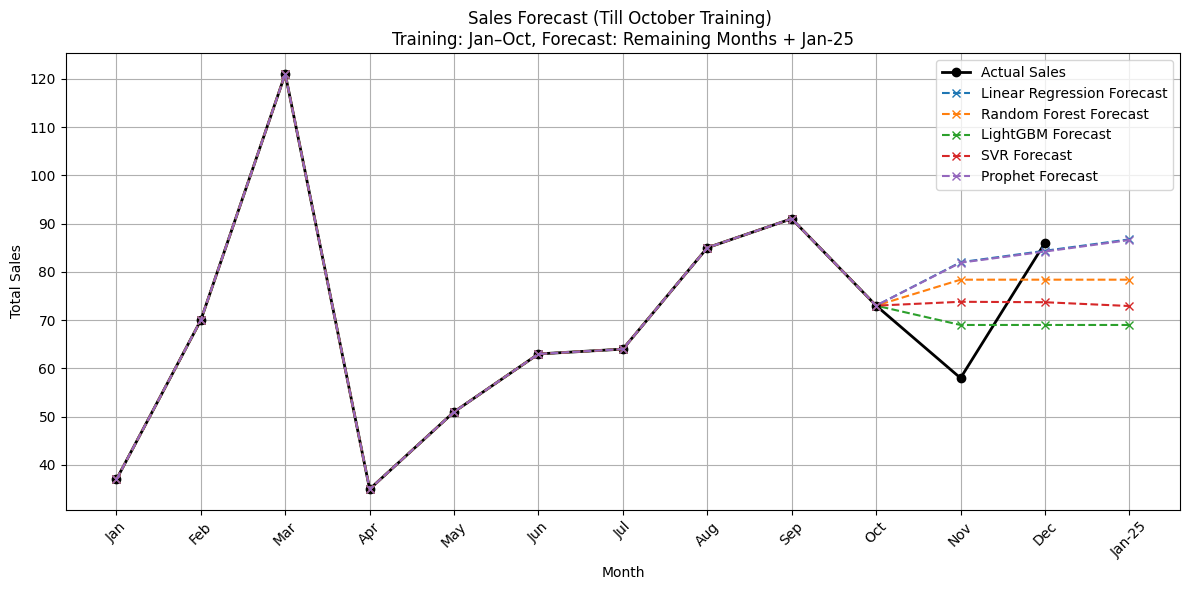


Error Metrics for Forecasts with Training Till October (Forecast months with actual data):
  Linear Regression: MAE = 12.82
  Random Forest: MAE = 14.00
  LightGBM: MAE = 14.00
  SVR: MAE = 14.05
  Prophet: MAE = 12.85
------------------------------------------------------------


22:30:11 - cmdstanpy - INFO - Chain [1] start processing
22:30:11 - cmdstanpy - INFO - Chain [1] done processing


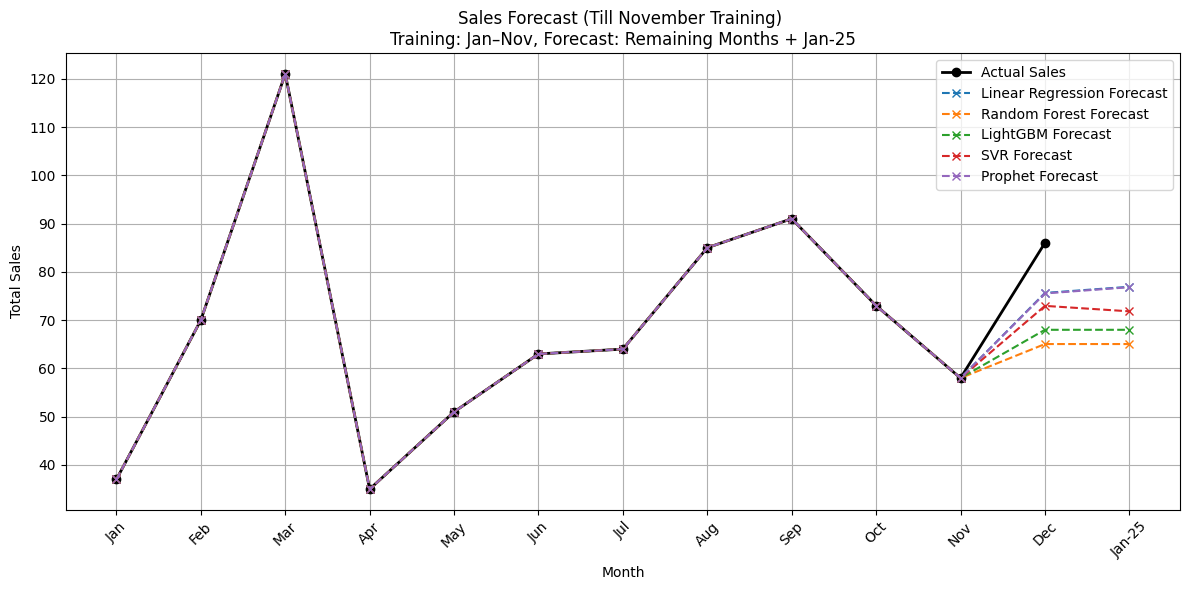

22:30:11 - cmdstanpy - INFO - Chain [1] start processing



Error Metrics for Forecasts with Training Till November (Forecast months with actual data):
  Linear Regression: MAE = 10.36
  Random Forest: MAE = 20.95
  LightGBM: MAE = 18.00
  SVR: MAE = 13.05
  Prophet: MAE = 10.47
------------------------------------------------------------


22:30:11 - cmdstanpy - INFO - Chain [1] done processing


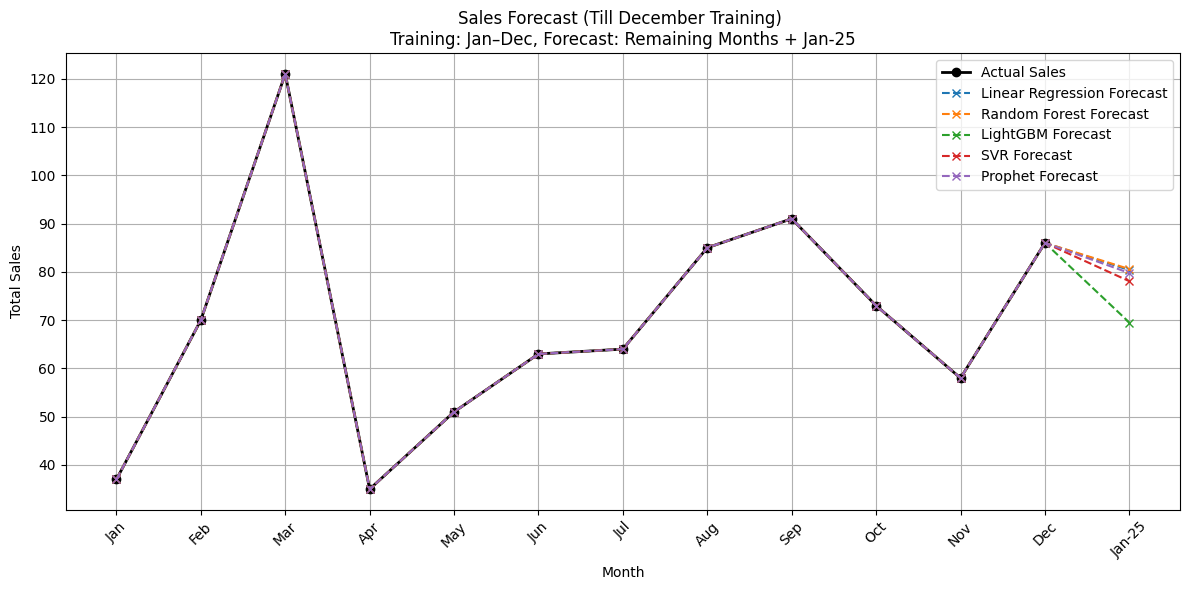


Error Metrics for Forecasts with Training Till December (Forecast months with actual data):
  Linear Regression: Not applicable (no forecast period with actual data)
  Random Forest: Not applicable (no forecast period with actual data)
  LightGBM: Not applicable (no forecast period with actual data)
  SVR: Not applicable (no forecast period with actual data)
  Prophet: Not applicable (no forecast period with actual data)
------------------------------------------------------------


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Machine Learning Models & Utilities
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# Prophet for time series forecasting
from prophet import Prophet

# For integer-only y-axis ticks
from matplotlib.ticker import MaxNLocator

# -----------------------------------
# 1. Data Preparation & Feature Engineering
# -----------------------------------
# Monthly sales data (January to December 2024)
data = {
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'Total Sales': [37, 70, 121, 35, 51, 63, 64, 85, 91, 73, 58, 86]
}
df = pd.DataFrame(data)
df['Month_Num'] = range(1, len(df) + 1)  # 1 = Jan, 2 = Feb, ..., 12 = Dec

# Full x-axis labels (months 1-12, plus "Jan-25" for January of next year)
month_labels_full = list(df['Month']) + ['Jan-25']

# -----------------------------------
# 2. Define the Models
# -----------------------------------
ml_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
}
# Prophet will be handled separately.

# -----------------------------------
# 3. Forecasting Function for a Given Cutoff
# -----------------------------------
def forecast_with_cutoff(cutoff):
    """
    Train models using data from January up to the cutoff month (cutoff: integer, e.g., 8 for August).
    Forecast for the remaining months up to December plus January of next year (month 13).
    Compute MAE for forecasted months where actual data exists (i.e., forecast months  = cutoff+1 ... 12).
    
    Returns:
      predicted_series: dict with keys as model names (including 'Prophet') and values as list of 13 forecast values.
      error_metrics: dict with MAE for each model (computed over months cutoff+1..12).
    """
    # Use data up to the cutoff month
    train_df = df[df['Month_Num'] <= cutoff].copy()
    X_train = train_df[['Month_Num']]
    y_train = train_df['Total Sales']
    
    # Future months for forecasting: from cutoff+1 to 13 (where 13 represents Jan of next year)
    future_months_arr = np.arange(cutoff + 1, 14).reshape(-1, 1)
    
    # Scale feature(s) for ML models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    future_months_scaled = scaler.transform(future_months_arr)
    
    predicted_series = {}
    error_metrics = {}  # MAE computed for forecast months that have actual data (months cutoff+1 .. 12)
    
    # --- ML Models Forecasts ---
    for name, model in ml_models.items():
        model.fit(X_train_scaled, y_train)
        pred = model.predict(future_months_scaled)
        # Force any negative predictions to 0
        pred = np.maximum(pred, 0)
        # Build full series: for months 1..cutoff, use actual; for months cutoff+1..13, use predictions.
        full_series = list(train_df['Total Sales']) + list(pred)
        predicted_series[name] = full_series
        
        # Compute MAE only for forecast months with actual data (i.e. months cutoff+1..12)
        forecast_months_with_actual = np.arange(cutoff + 1, 13)
        if len(forecast_months_with_actual) > 0:
            actual_vals = df[df['Month_Num'].isin(forecast_months_with_actual)]['Total Sales'].values
            pred_vals = pred[:len(forecast_months_with_actual)]
            mae = mean_absolute_error(actual_vals, pred_vals)
            error_metrics[name] = mae
        else:
            error_metrics[name] = None

    # --- Prophet Forecast ---
    # Prepare Prophet training data using dates.
    prophet_train_df = pd.DataFrame({
        'ds': [datetime(2024, int(m), 1) for m in train_df['Month_Num']],
        'y': train_df['Total Sales']
    })
    prophet_model = Prophet()
    prophet_model.fit(prophet_train_df)
    # Forecast n_periods = (12 - cutoff) + 1 months (month 13 included)
    n_periods = (12 - cutoff) + 1
    future_dates = prophet_model.make_future_dataframe(periods=n_periods, freq='M')
    forecast_df = prophet_model.predict(future_dates)
    prophet_forecast = forecast_df.iloc[-n_periods:]['yhat'].values
    prophet_forecast = np.maximum(prophet_forecast, 0)
    full_series = list(train_df['Total Sales']) + list(prophet_forecast)
    predicted_series['Prophet'] = full_series
    if cutoff < 12:
        forecast_months_with_actual = np.arange(cutoff + 1, 13)
        actual_vals = df[df['Month_Num'].isin(forecast_months_with_actual)]['Total Sales'].values
        pred_vals = prophet_forecast[:len(forecast_months_with_actual)]
        mae = mean_absolute_error(actual_vals, pred_vals)
        error_metrics['Prophet'] = mae
    else:
        error_metrics['Prophet'] = None
        
    return predicted_series, error_metrics

# -----------------------------------
# 4. Loop Over Cutoff Scenarios: Till August, October, November, and December
# -----------------------------------
cutoff_scenarios = {
    'Till August': 8,
    'Till October': 10,
    'Till November': 11,
    'Till December': 12
}

for scenario, cutoff in cutoff_scenarios.items():
    print("=" * 80)
    print(f"Scenario: Training Data Till {scenario} (i.e. up to month {cutoff})")
    predicted_series, error_metrics = forecast_with_cutoff(cutoff)
    
    # Create full x-axis labels (13 months: Jan-Dec 2024 and Jan-25)
    x_labels = month_labels_full
    
    # Actual series: actual values for months 1-12 and NaN for month 13 (Jan-25)
    actual_series = list(df['Total Sales']) + [np.nan]
    
    # -----------------------------------
    # Print Real and Predicted Values
    # -----------------------------------
    print("\nReal (Actual) Sales Values (Months Jan to Dec):")
    for m, val in zip(df['Month'], df['Total Sales']):
        print(f"  {m}: {val}")
    print("  Jan-25: N/A")
    
    print("\nPredicted Values for Each Model (Full Series: Jan to Jan-25):")
    for model_name, series in predicted_series.items():
        # Print the series with corresponding month labels.
        print(f"\n{model_name}:")
        for month, value in zip(x_labels, series):
            # Round value to 2 decimals
            print(f"  {month}: {value:.2f}")
    
    # -----------------------------------
    # Plotting
    # -----------------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(x_labels, actual_series, label='Actual Sales', marker='o', linewidth=2, color='black')
    for name, series in predicted_series.items():
        plt.plot(x_labels, series, linestyle='--', marker='x', label=f'{name} Forecast')
    
    cutoff_month = df.loc[df["Month_Num"] == cutoff, "Month"].values[0]
    plt.title(f'Sales Forecast ({scenario} Training)\nTraining: Jan–{cutoff_month}, Forecast: Remaining Months + Jan-25')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # -----------------------------------
    # Print Error Metrics
    # -----------------------------------
    print("\nError Metrics (MAE) for Forecasted Months with Actual Data:")
    for model_name, mae in error_metrics.items():
        if mae is not None:
            print(f"  {model_name}: MAE = {mae:.2f}")
        else:
            print(f"  {model_name}: Not applicable (no forecast period with actual data)")
    print("=" * 80, "\n")
